In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

#1. DATA LOAD
with open('benchmark_results.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Convert all relevant columns into numerical values
hw_cols = ['time_sec', 'ram_mb', 'vram_mb', 'cpu_percent', 'gpu_util_percent']
ml_cols = ['accuracy', 'precision', 'recall', 'f1_score', 'auc', 'fpr']

for col in hw_cols + ml_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Help function for labeling bars
def show_values(ax, space=0.01, is_percent=False):
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height()
        if not pd.isna(_y) and _y > 0:
            val = p.get_height()
            label = '{:.2f}'.format(val) if is_percent and val <= 1.0 else '{:.1f}'.format(val)
            ax.text(_x, _y + (_y * space), label, ha="center", fontsize=9, fontweight='bold')

# --- PLOT FUNCTION ---
def generate_benchmark_plots(plot_df, title_suffix):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(4, 3, figsize=(18, 22))
    fig.suptitle(f'KI Modell Benchmark: {title_suffix}', fontsize=20, weight='bold')
    
    # 1. Training time
    train_df = plot_df[plot_df['task'] == 'Training']
    if not train_df.empty:
        sns.barplot(ax=axes[0, 0], data=train_df, x='model', y='time_sec', hue='model', palette='viridis', legend=False)
        axes[0, 0].set_title('Trainingszeit (s) - Weniger ist besser')
        show_values(axes[0, 0])

    # 2. Inference time
    inf_df = plot_df[plot_df['task'] == 'Inferenz']
    if not inf_df.empty:
        sns.barplot(ax=axes[0, 1], data=inf_df, x='model', y='time_sec', hue='model', palette='magma', legend=False)
        axes[0, 1].set_title('Inferenzzeit (s) - Weniger ist besser')
        show_values(axes[0, 1])

    #3. GPU utilization
    sns.barplot(ax=axes[0, 2], data=plot_df, x='model', y='gpu_util_percent', hue='task', palette='Blues')
    axes[0, 2].set_title('GPU Auslastung (%)')
    show_values(axes[0, 2])

    #4. CPU utilization
    sns.barplot(ax=axes[1, 0], data=plot_df, x='model', y='cpu_percent', hue='task', palette='Oranges')
    axes[1, 0].set_title('CPU Auslastung (%)')
    show_values(axes[1, 0])

    # 5. VRAM
    sns.barplot(ax=axes[1, 1], data=plot_df, x='model', y='vram_mb', hue='task', palette='Purples')
    axes[1, 1].set_title('VRAM Nutzung (MB)')
    show_values(axes[1, 1])

    # 6. RAM
    sns.barplot(ax=axes[1, 2], data=plot_df, x='model', y='ram_mb', hue='task', palette='Greens')
    axes[1, 2].set_title('RAM Nutzung (MB)')
    show_values(axes[1, 2])

   # ML metrics (inference only)
    if not inf_df.empty:
        metrics = [('accuracy', 'Accuracy', 2, 0), ('precision', 'Precision', 2, 1), 
                   ('recall', 'Recall', 2, 2), ('f1_score', 'F1-Score', 3, 0), 
                   ('fpr', 'False Positive Rate', 3, 1), ('auc', 'AUC', 3, 2)]
        
        for col, label, r, c in metrics:
            if col in inf_df.columns:
                sns.barplot(ax=axes[r, c], data=inf_df, x='model', y=col, hue='model', palette='coolwarm', legend=False)
                axes[r, c].set_title(f'{label}')
                if col != 'fpr': axes[r, c].set_ylim(0, 1.1)
                show_values(axes[r, c], is_percent=True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# --- ANALYSIS PROCESS ---

# Definition of base models (without PhiUSIIL)
base_model_names = ['CNN', 'Logistic Regression', 'Linear SVC', 'XGBoost']
df_base = df[df['model'].isin(base_model_names)].copy()


Erzeuge Analyse für Basismodelle...


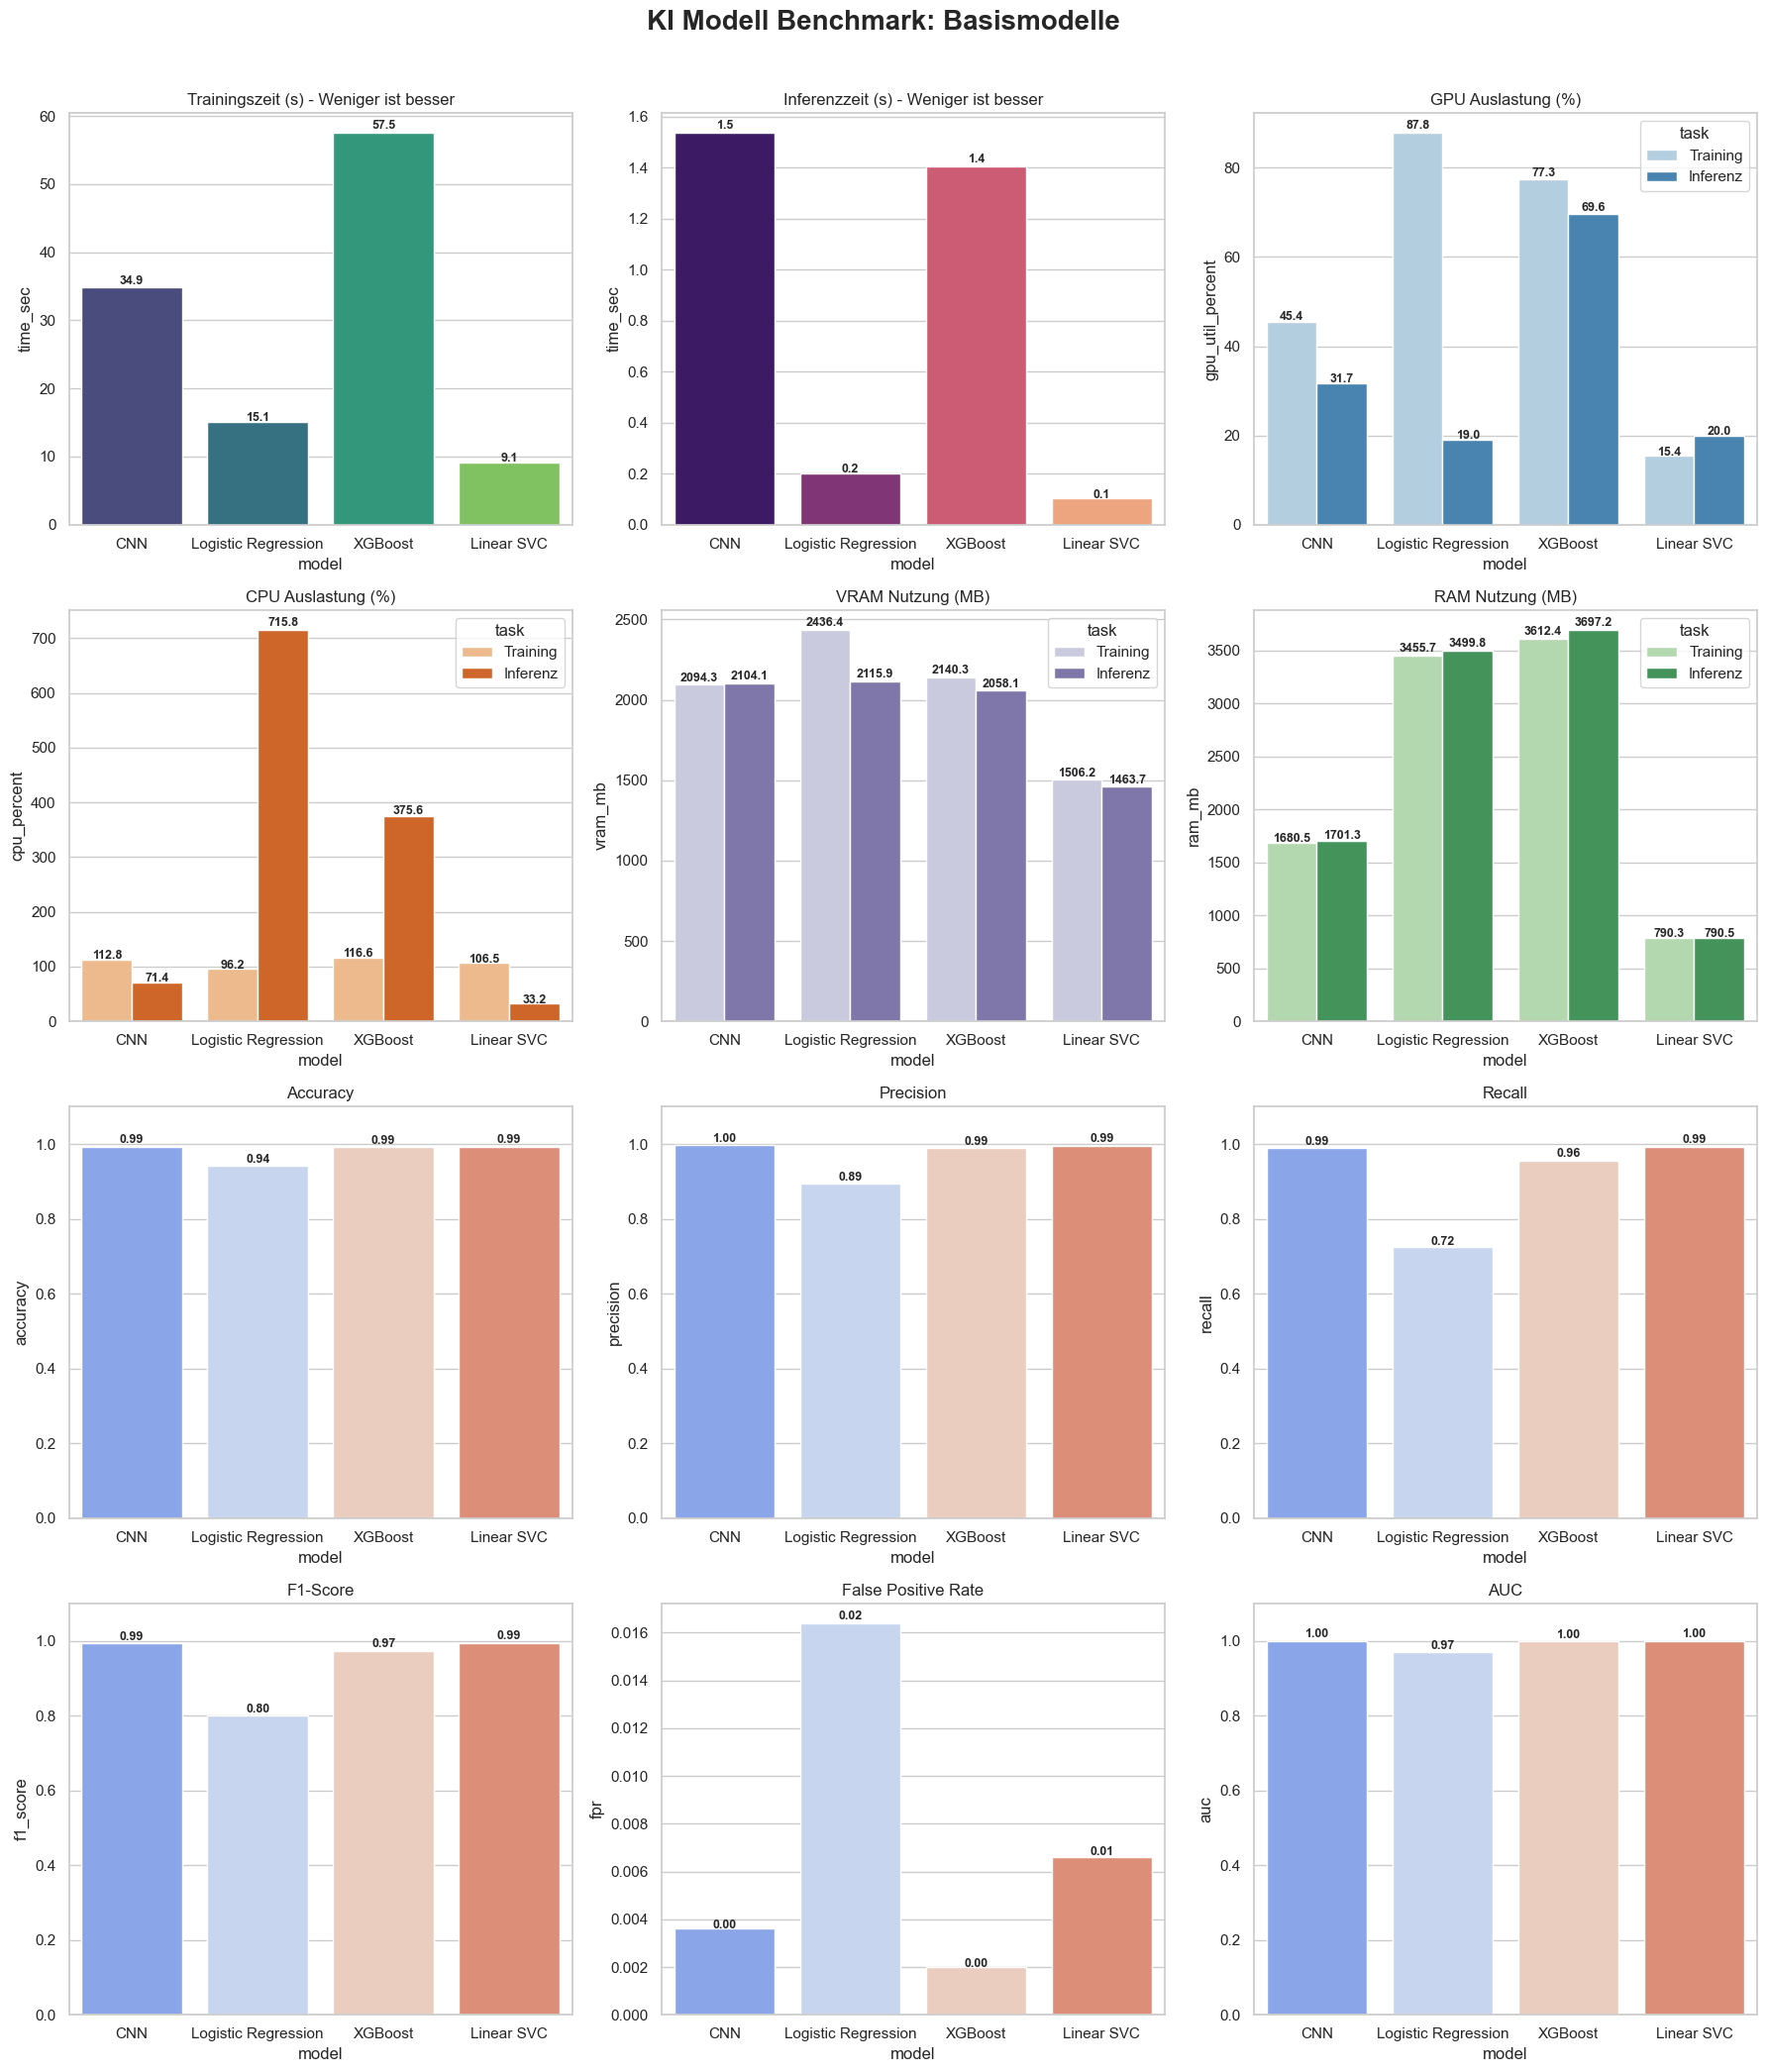

In [ ]:
# 1. Part: Comparison of the basic models
print("Erzeuge Analyse für Basismodelle...")
generate_benchmark_plots(df_base, "Basismodelle")

Erzeuge Vergleich für CNN vs. CNN PhiUSIIL...


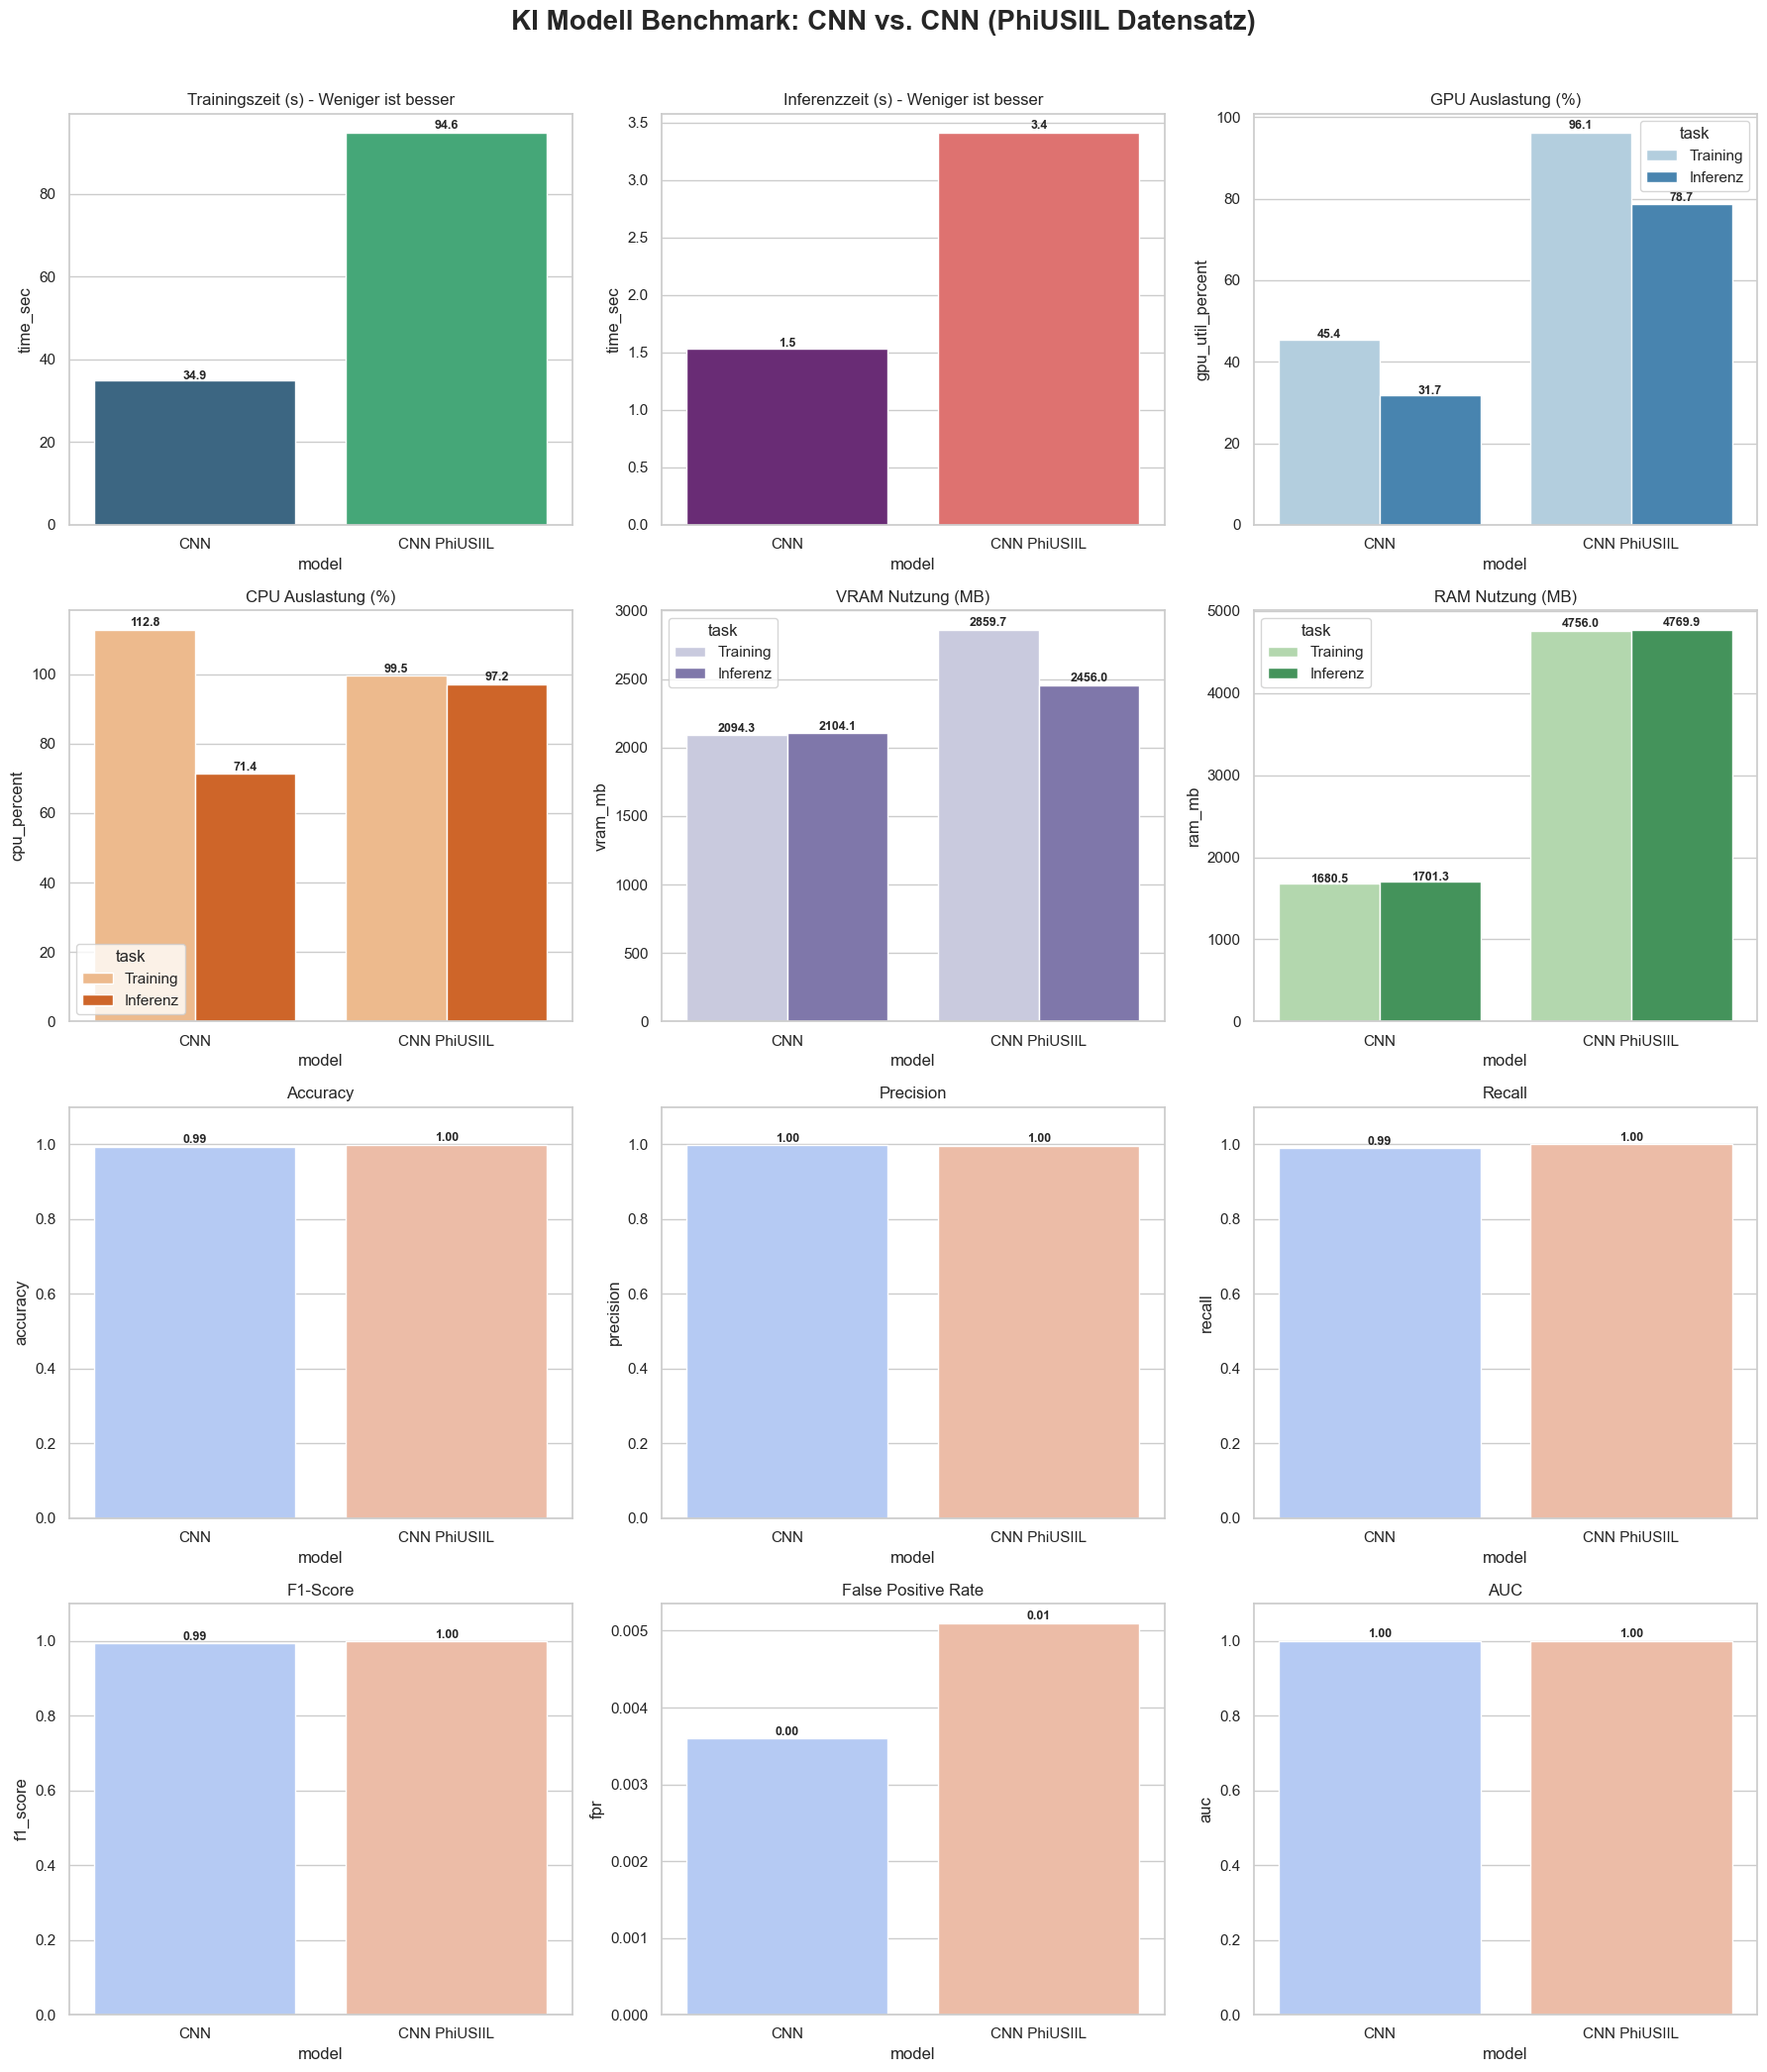

In [ ]:
# 2nd Part: Comparison of a specific model with its PhiUSIIL variant
# Beispiel: CNN vs CNN PhiUSIIL
target_base = 'CNN'
df_compare = df[df['model'].isin([target_base, f"{target_base} PhiUSIIL"])].copy()

print(f"Erzeuge Vergleich für {target_base} vs. {target_base} PhiUSIIL...")
generate_benchmark_plots(df_compare, f"{target_base} vs. {target_base} (PhiUSIIL Datensatz)")

Erzeuge Vergleich für Logistic Regression vs. Logistic Regression PhiUSIIL...


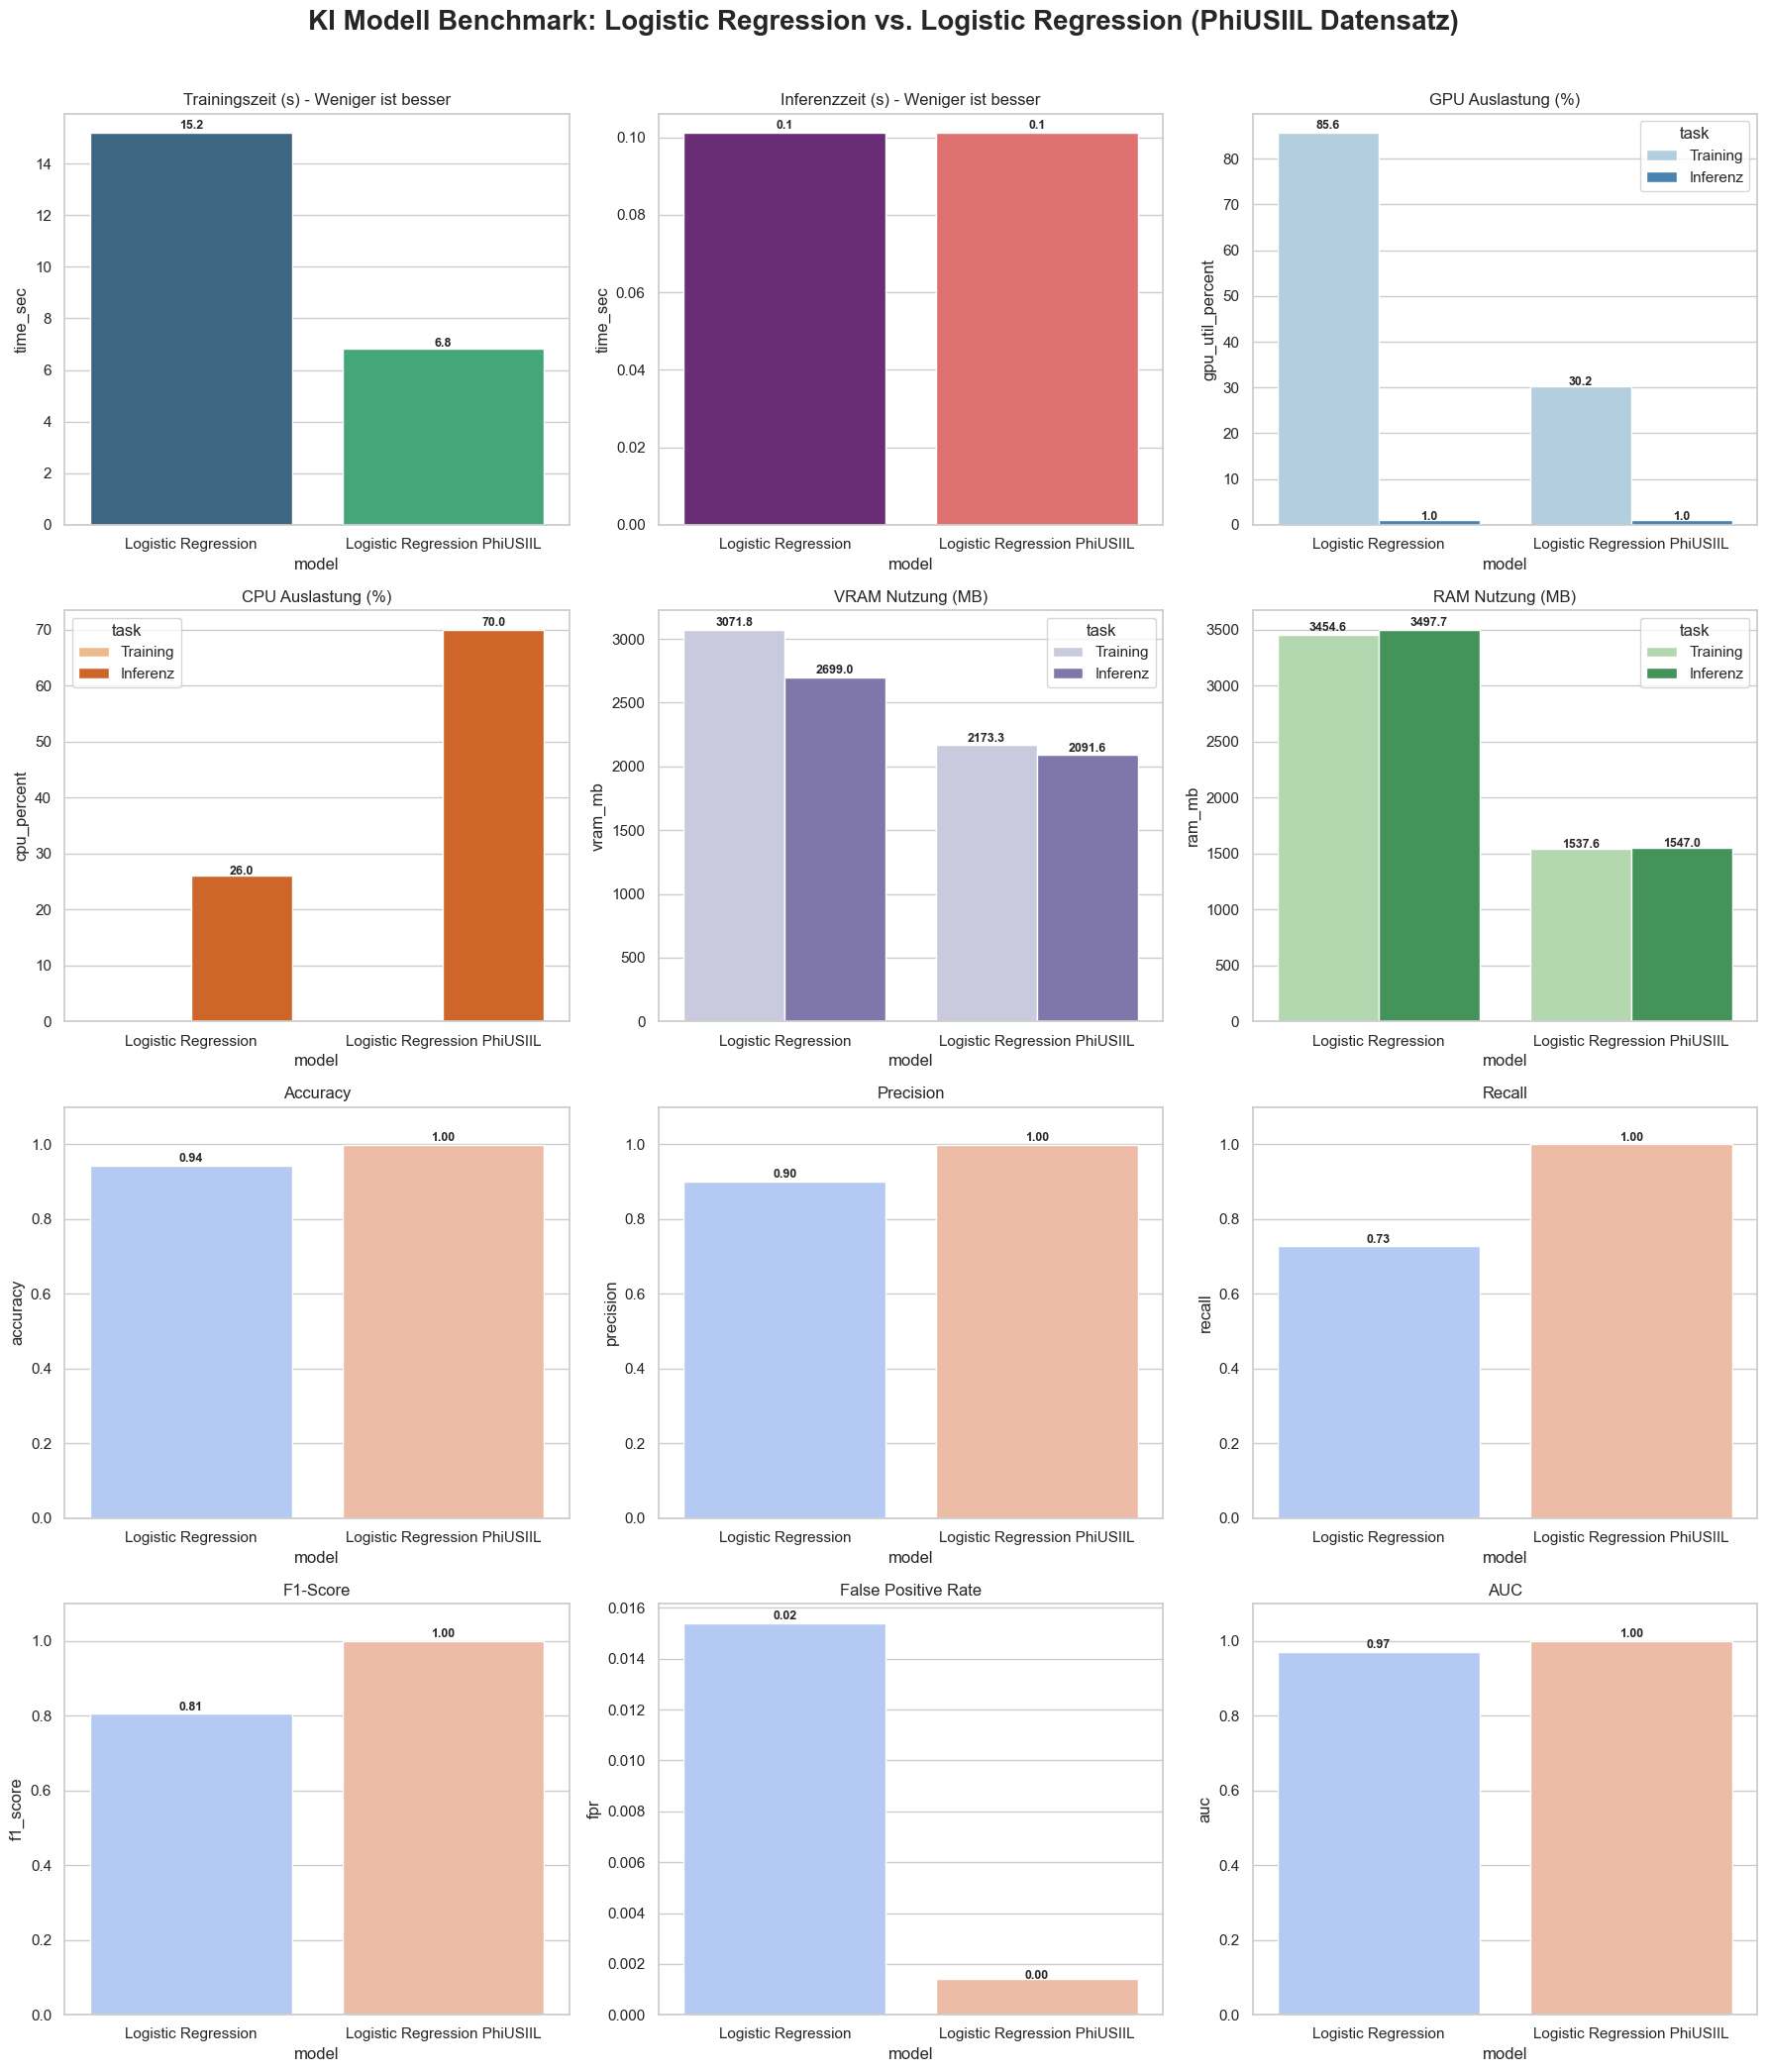

In [20]:
#Logistic Regressionvs Logistic Regression PhiUSIIL
target_base = 'Logistic Regression'
df_compare = df[df['model'].isin([target_base, f"{target_base} PhiUSIIL"])].copy()

print(f"Erzeuge Vergleich für {target_base} vs. {target_base} PhiUSIIL...")
generate_benchmark_plots(df_compare, f"{target_base} vs. {target_base} (PhiUSIIL Datensatz)")

Erzeuge Vergleich für Linear SVC vs. Linear SVC PhiUSIIL...


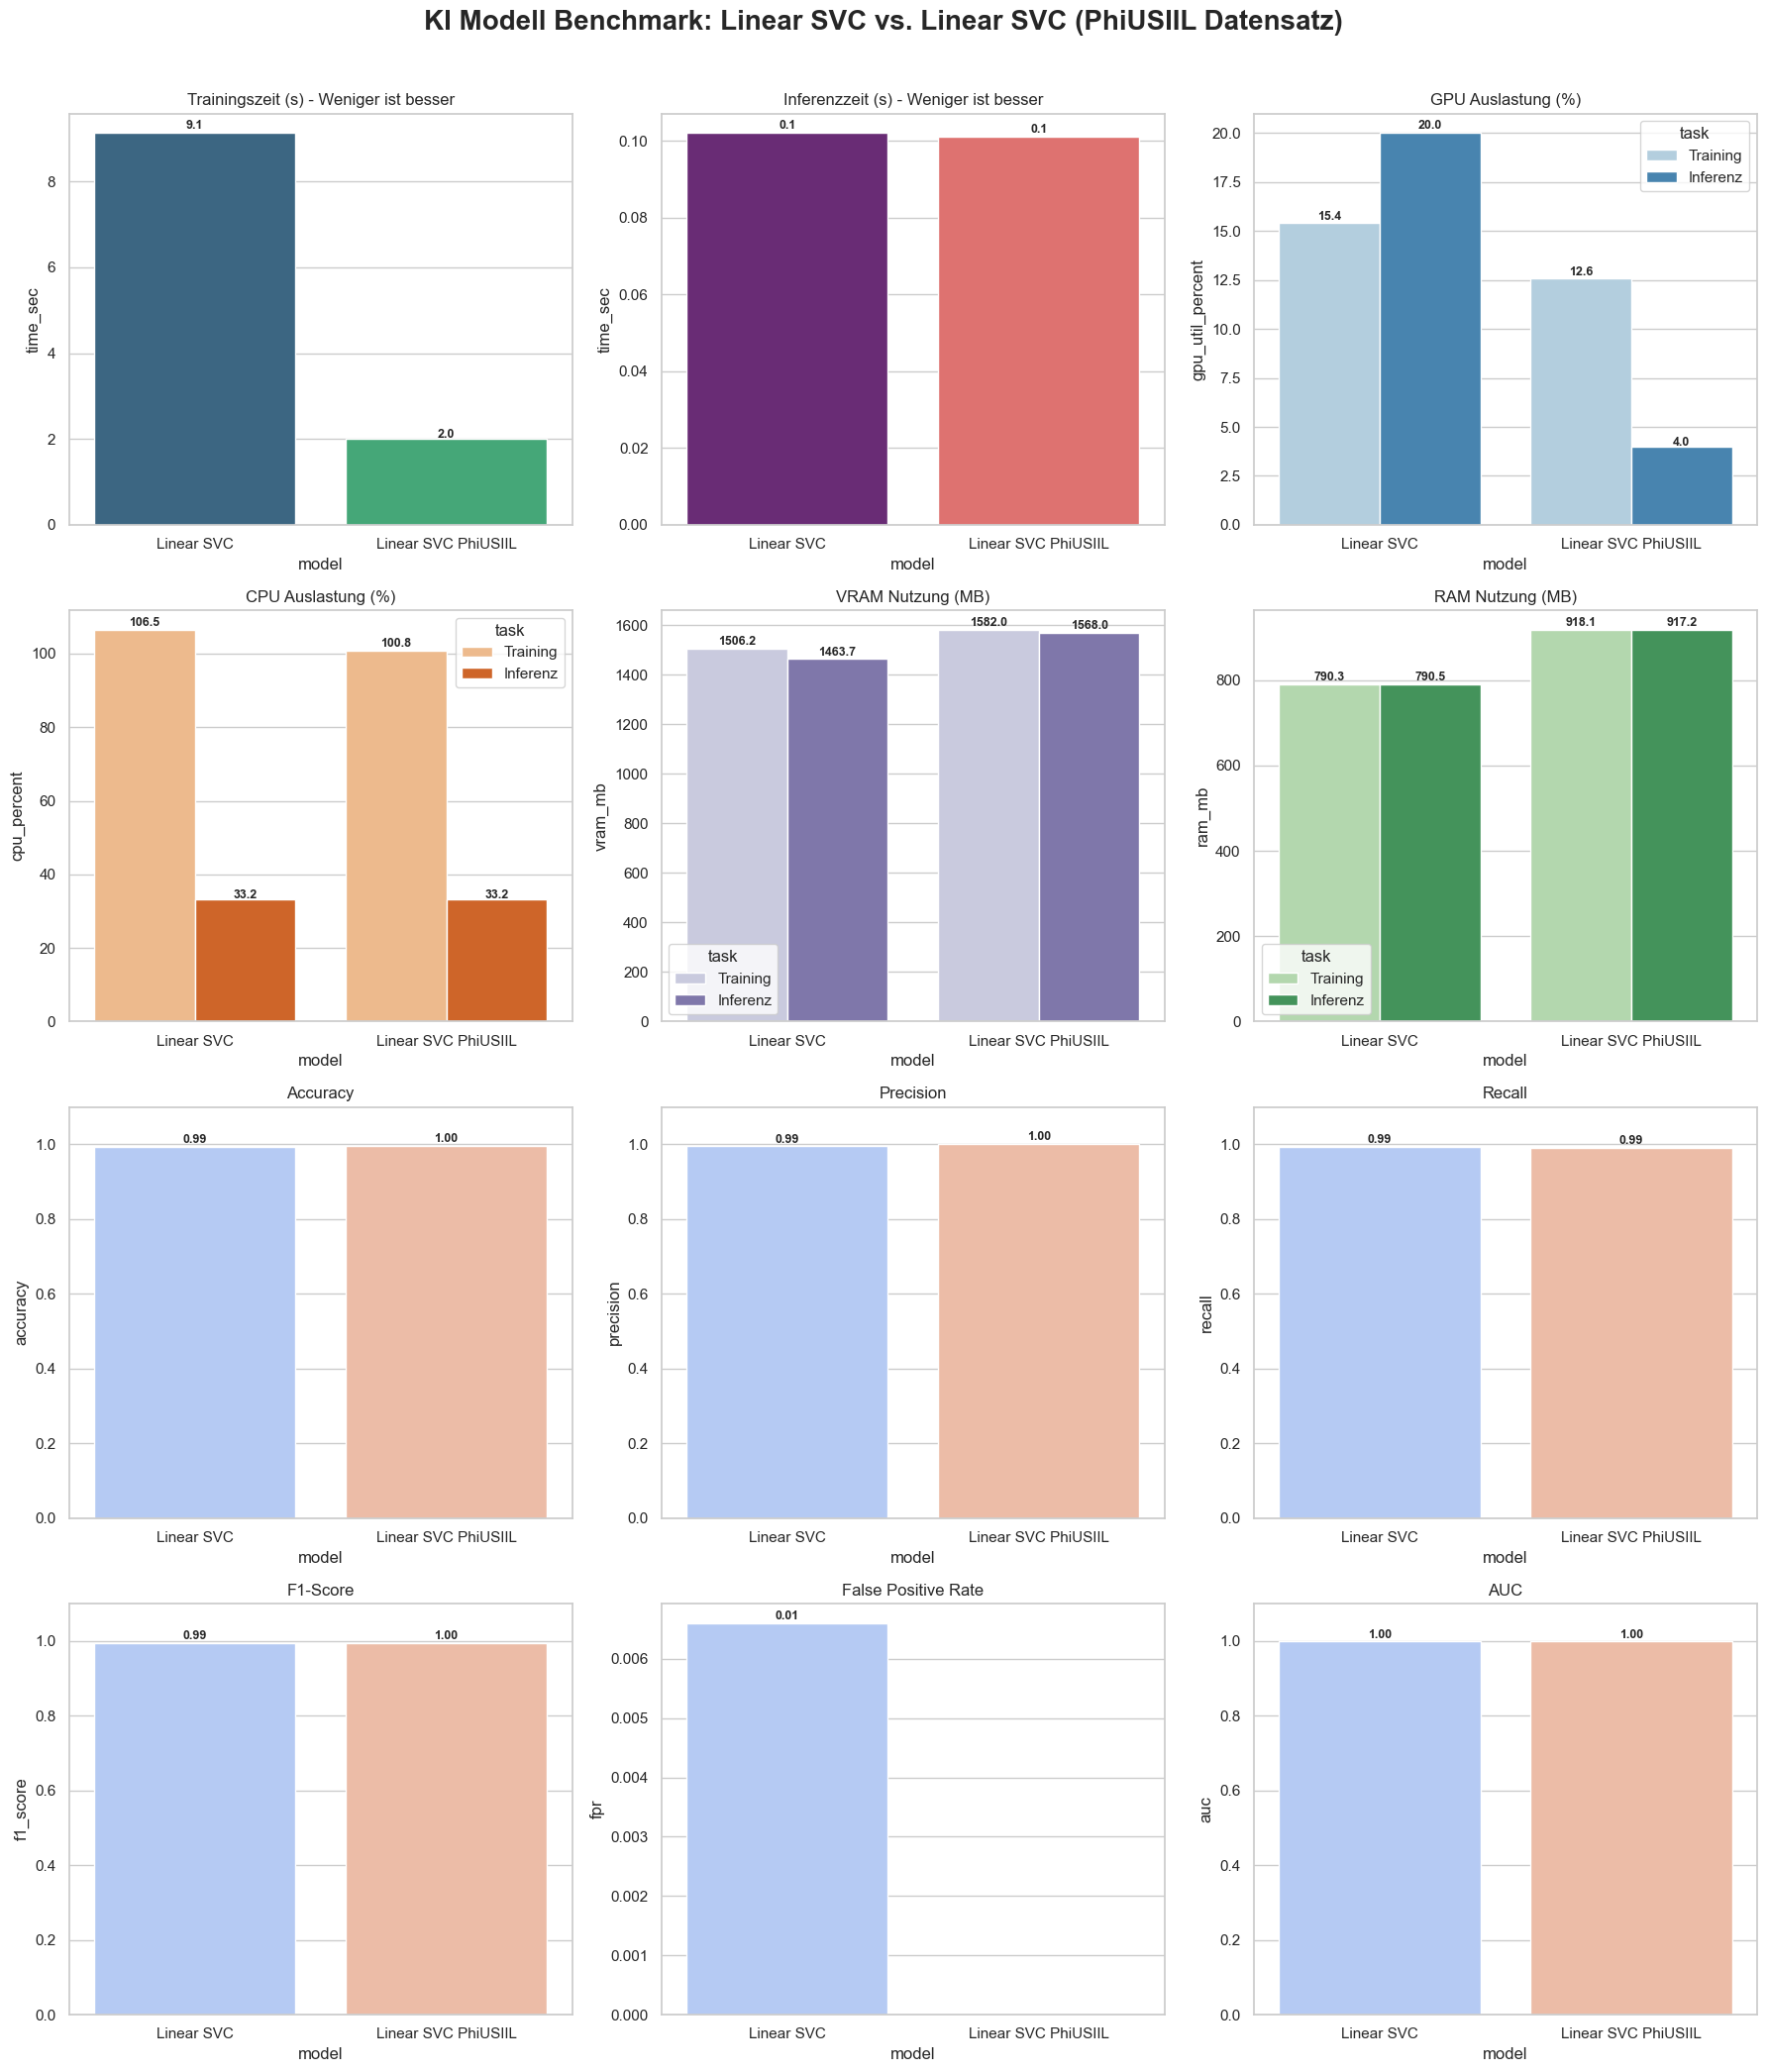

In [4]:
# Linear SVC vs Linear SVC PhiUSIIL
target_base = 'Linear SVC'
df_compare = df[df['model'].isin([target_base, f"{target_base} PhiUSIIL"])].copy()

print(f"Erzeuge Vergleich für {target_base} vs. {target_base} PhiUSIIL...")
generate_benchmark_plots(df_compare, f"{target_base} vs. {target_base} (PhiUSIIL Datensatz)")

Erzeuge Vergleich für XGBoost vs. XGBoost PhiUSIIL...


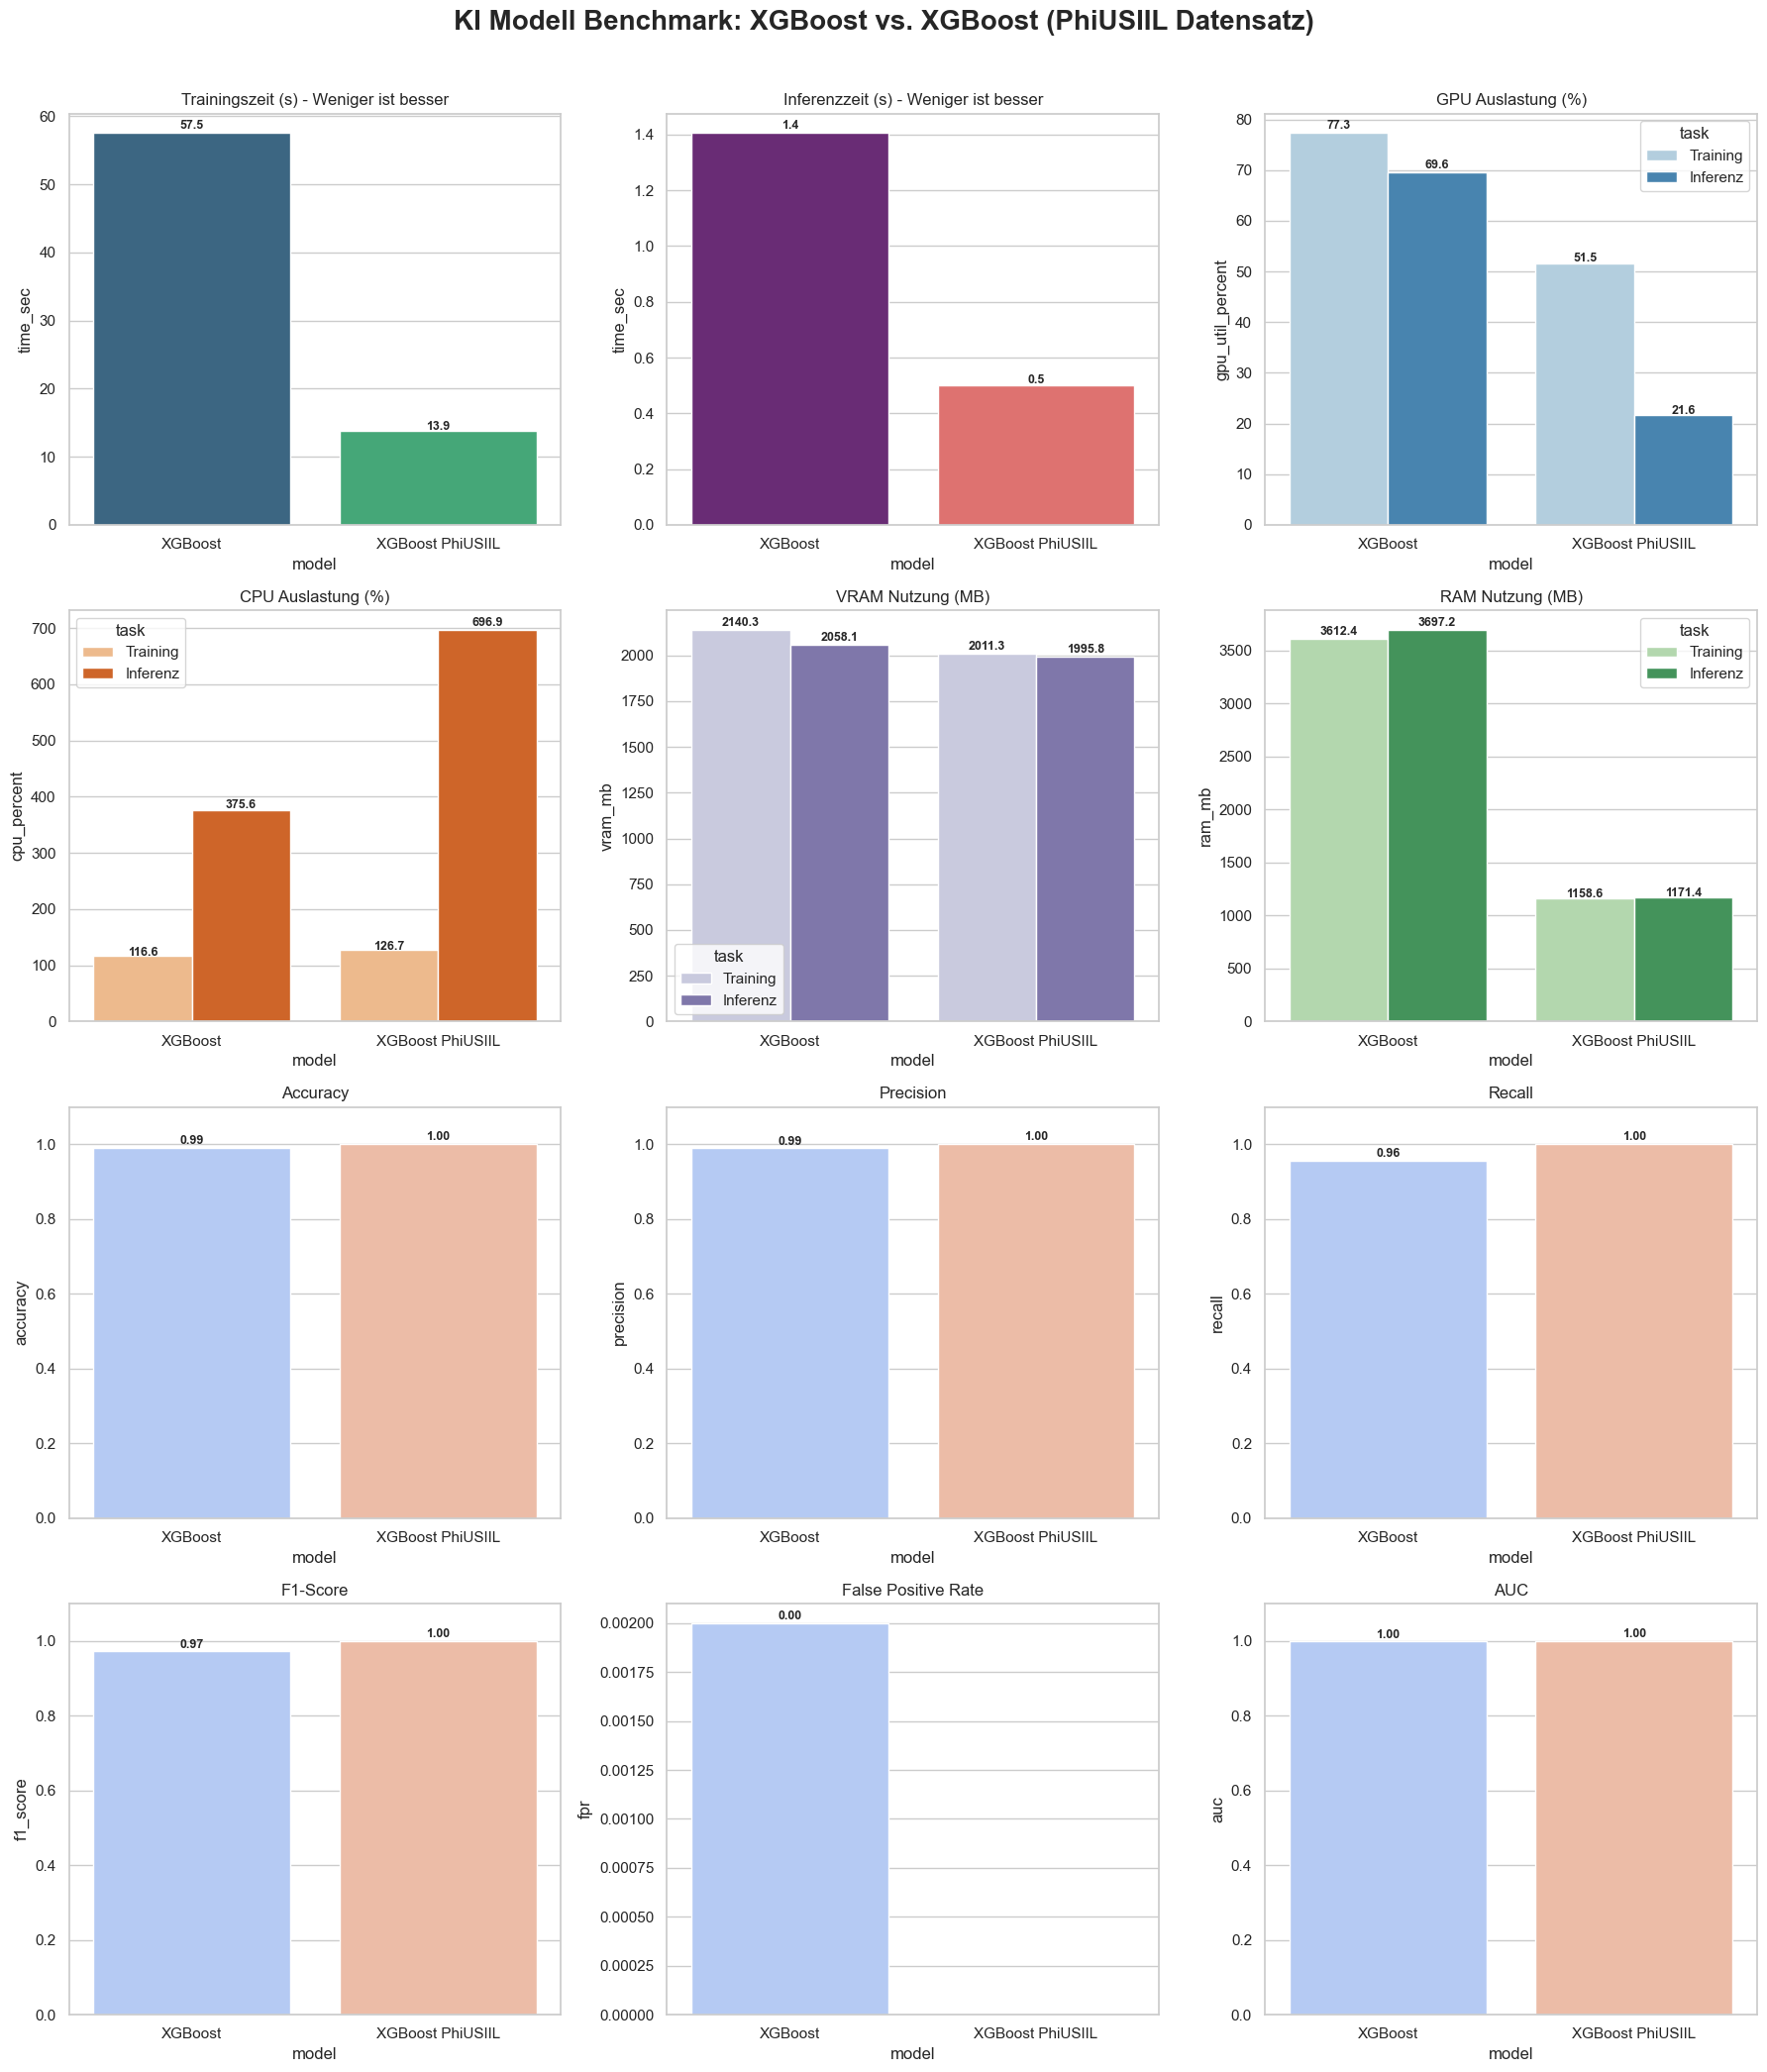

In [5]:
# Beispiel: XGBoost vs XGBoost PhiUSIIL
target_base = 'XGBoost'
df_compare = df[df['model'].isin([target_base, f"{target_base} PhiUSIIL"])].copy()

print(f"Erzeuge Vergleich für {target_base} vs. {target_base} PhiUSIIL...")
generate_benchmark_plots(df_compare, f"{target_base} vs. {target_base} (PhiUSIIL Datensatz)")